In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 16:44:29.380961: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 16:44:29.381011: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.3)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

scan_schedule = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in scan_schedule:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/119


2022-05-07 16:44:34.124231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 16:44:34.124287: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 16:44:34.124319: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 16:44:34.124626: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


130/130 [==============================] - 3s 12ms/step - loss: 0.7090 - accuracy: 0.5017 - auc: 0.5041 - val_loss: 0.6889 - val_accuracy: 0.4977 - val_auc: 0.5550
Epoch 2/119
130/130 [==============================] - 1s 7ms/step - loss: 0.6981 - accuracy: 0.4996 - auc: 0.5376 - val_loss: 0.6816 - val_accuracy: 0.5095 - val_auc: 0.6234
Epoch 3/119
130/130 [==============================] - 1s 9ms/step - loss: 0.6911 - accuracy: 0.5040 - auc: 0.5673 - val_loss: 0.6774 - val_accuracy: 0.5127 - val_auc: 0.6697
Epoch 4/119
130/130 [==============================] - 1s 8ms/step - loss: 0.6880 - accuracy: 0.5075 - auc: 0.5838 - val_loss: 0.6745 - val_accuracy: 0.5151 - val_auc: 0.7019
Epoch 5/119
130/130 [==============================] - 1s 9ms/step - loss: 0.6850 - accuracy: 0.5133 - auc: 0.5978 - val_loss: 0.6719 - val_accuracy: 0.5164 - val_auc: 0.7285
Epoch 6/119
130/130 [==============================] - 1s 8ms/step - loss: 0.6817 - accuracy: 0.5182 - auc: 0.6098 - val_loss: 0.6695 - 

Epoch 48/119
130/130 [==============================] - 1s 7ms/step - loss: 0.5384 - accuracy: 0.7455 - auc: 0.8317 - val_loss: 0.4947 - val_accuracy: 0.8582 - val_auc: 0.9401
Epoch 49/119
130/130 [==============================] - 1s 9ms/step - loss: 0.5306 - accuracy: 0.7502 - auc: 0.8381 - val_loss: 0.4878 - val_accuracy: 0.8598 - val_auc: 0.9413
Epoch 50/119
130/130 [==============================] - 1s 8ms/step - loss: 0.5261 - accuracy: 0.7532 - auc: 0.8406 - val_loss: 0.4814 - val_accuracy: 0.8607 - val_auc: 0.9424
Epoch 51/119
130/130 [==============================] - 1s 8ms/step - loss: 0.5223 - accuracy: 0.7549 - auc: 0.8411 - val_loss: 0.4754 - val_accuracy: 0.8619 - val_auc: 0.9435
Epoch 52/119
130/130 [==============================] - 1s 8ms/step - loss: 0.5163 - accuracy: 0.7594 - auc: 0.8455 - val_loss: 0.4689 - val_accuracy: 0.8632 - val_auc: 0.9446
Epoch 53/119
130/130 [==============================] - 1s 8ms/step - loss: 0.5122 - accuracy: 0.7606 - auc: 0.8466 - va

130/130 [==============================] - 1s 8ms/step - loss: 0.3964 - accuracy: 0.8162 - auc: 0.9029 - val_loss: 0.3411 - val_accuracy: 0.8602 - val_auc: 0.9626
Epoch 95/119
130/130 [==============================] - 1s 7ms/step - loss: 0.4002 - accuracy: 0.8141 - auc: 0.9000 - val_loss: 0.3380 - val_accuracy: 0.8626 - val_auc: 0.9627
Epoch 96/119
130/130 [==============================] - 1s 8ms/step - loss: 0.3941 - accuracy: 0.8170 - auc: 0.9033 - val_loss: 0.3387 - val_accuracy: 0.8608 - val_auc: 0.9628
Epoch 97/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3977 - accuracy: 0.8142 - auc: 0.9012 - val_loss: 0.3380 - val_accuracy: 0.8608 - val_auc: 0.9630
Epoch 98/119
130/130 [==============================] - 1s 8ms/step - loss: 0.3960 - accuracy: 0.8149 - auc: 0.9021 - val_loss: 0.3379 - val_accuracy: 0.8597 - val_auc: 0.9631
Epoch 99/119
130/130 [==============================] - 1s 8ms/step - loss: 0.3966 - accuracy: 0.8160 - auc: 0.9019 - val_loss: 0.335

130/130 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0.6951 - auc: 0.7942 - val_loss: 0.5716 - val_accuracy: 0.8266 - val_auc: 0.9212
Epoch 21/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5891 - accuracy: 0.7071 - auc: 0.8045 - val_loss: 0.5623 - val_accuracy: 0.8313 - val_auc: 0.9243
Epoch 22/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5843 - accuracy: 0.7066 - auc: 0.8047 - val_loss: 0.5543 - val_accuracy: 0.8374 - val_auc: 0.9268
Epoch 23/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5761 - accuracy: 0.7171 - auc: 0.8114 - val_loss: 0.5458 - val_accuracy: 0.8431 - val_auc: 0.9290
Epoch 24/119
130/130 [==============================] - 1s 6ms/step - loss: 0.5704 - accuracy: 0.7253 - auc: 0.8166 - val_loss: 0.5373 - val_accuracy: 0.8468 - val_auc: 0.9314
Epoch 25/119
130/130 [==============================] - 1s 5ms/step - loss: 0.5654 - accuracy: 0.7245 - auc: 0.8169 - val_loss: 0.529

130/130 [==============================] - 1s 5ms/step - loss: 0.3935 - accuracy: 0.8180 - auc: 0.9039 - val_loss: 0.3309 - val_accuracy: 0.8692 - val_auc: 0.9621
Epoch 67/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3915 - accuracy: 0.8215 - auc: 0.9051 - val_loss: 0.3276 - val_accuracy: 0.8705 - val_auc: 0.9622
Epoch 68/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3897 - accuracy: 0.8205 - auc: 0.9057 - val_loss: 0.3300 - val_accuracy: 0.8671 - val_auc: 0.9624
Epoch 69/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3906 - accuracy: 0.8181 - auc: 0.9049 - val_loss: 0.3242 - val_accuracy: 0.8716 - val_auc: 0.9624
Epoch 70/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3896 - accuracy: 0.8213 - auc: 0.9057 - val_loss: 0.3258 - val_accuracy: 0.8697 - val_auc: 0.9625
Epoch 71/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3871 - accuracy: 0.8200 - auc: 0.9066 - val_loss: 0.325

130/130 [==============================] - 1s 5ms/step - loss: 0.3523 - accuracy: 0.8409 - auc: 0.9232 - val_loss: 0.3252 - val_accuracy: 0.8550 - val_auc: 0.9646
Epoch 113/119
130/130 [==============================] - 1s 7ms/step - loss: 0.3523 - accuracy: 0.8395 - auc: 0.9232 - val_loss: 0.3278 - val_accuracy: 0.8533 - val_auc: 0.9646
Epoch 114/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3515 - accuracy: 0.8427 - auc: 0.9233 - val_loss: 0.3288 - val_accuracy: 0.8520 - val_auc: 0.9646
Epoch 115/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3526 - accuracy: 0.8401 - auc: 0.9228 - val_loss: 0.3311 - val_accuracy: 0.8497 - val_auc: 0.9646
Epoch 116/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3546 - accuracy: 0.8367 - auc: 0.9220 - val_loss: 0.3267 - val_accuracy: 0.8532 - val_auc: 0.9647
Epoch 117/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3537 - accuracy: 0.8395 - auc: 0.9220 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.4432 - accuracy: 0.7934 - auc: 0.8814 - val_loss: 0.3812 - val_accuracy: 0.8648 - val_auc: 0.9565
Epoch 39/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4409 - accuracy: 0.7941 - auc: 0.8824 - val_loss: 0.3754 - val_accuracy: 0.8668 - val_auc: 0.9573
Epoch 40/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4325 - accuracy: 0.8012 - auc: 0.8875 - val_loss: 0.3700 - val_accuracy: 0.8677 - val_auc: 0.9577
Epoch 41/119
130/130 [==============================] - 1s 4ms/step - loss: 0.4297 - accuracy: 0.8007 - auc: 0.8881 - val_loss: 0.3686 - val_accuracy: 0.8647 - val_auc: 0.9583
Epoch 42/119
130/130 [==============================] - 1s 6ms/step - loss: 0.4253 - accuracy: 0.8035 - auc: 0.8903 - val_loss: 0.3636 - val_accuracy: 0.8656 - val_auc: 0.9589
Epoch 43/119
130/130 [==============================] - 1s 5ms/step - loss: 0.4212 - accuracy: 0.8069 - auc: 0.8921 - val_loss: 0.357

130/130 [==============================] - 1s 5ms/step - loss: 0.3616 - accuracy: 0.8337 - auc: 0.9187 - val_loss: 0.3308 - val_accuracy: 0.8492 - val_auc: 0.9642
Epoch 85/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3608 - accuracy: 0.8334 - auc: 0.9189 - val_loss: 0.3355 - val_accuracy: 0.8450 - val_auc: 0.9642
Epoch 86/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3583 - accuracy: 0.8378 - auc: 0.9202 - val_loss: 0.3336 - val_accuracy: 0.8460 - val_auc: 0.9643
Epoch 87/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3604 - accuracy: 0.8344 - auc: 0.9191 - val_loss: 0.3344 - val_accuracy: 0.8458 - val_auc: 0.9642
Epoch 88/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3584 - accuracy: 0.8368 - auc: 0.9201 - val_loss: 0.3322 - val_accuracy: 0.8471 - val_auc: 0.9643
Epoch 89/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3548 - accuracy: 0.8358 - auc: 0.9219 - val_loss: 0.335

130/130 [==============================] - 1s 4ms/step - loss: 0.6755 - accuracy: 0.5480 - auc: 0.6176 - val_loss: 0.6686 - val_accuracy: 0.5814 - val_auc: 0.6908
Epoch 11/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6738 - accuracy: 0.5578 - auc: 0.6276 - val_loss: 0.6661 - val_accuracy: 0.5975 - val_auc: 0.7040
Epoch 12/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6721 - accuracy: 0.5630 - auc: 0.6310 - val_loss: 0.6637 - val_accuracy: 0.6126 - val_auc: 0.7160
Epoch 13/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6685 - accuracy: 0.5741 - auc: 0.6446 - val_loss: 0.6612 - val_accuracy: 0.6260 - val_auc: 0.7273
Epoch 14/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6651 - accuracy: 0.5856 - auc: 0.6576 - val_loss: 0.6587 - val_accuracy: 0.6374 - val_auc: 0.7383
Epoch 15/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6639 - accuracy: 0.5912 - auc: 0.6612 - val_loss: 0.656

130/130 [==============================] - 1s 4ms/step - loss: 0.5349 - accuracy: 0.7476 - auc: 0.8310 - val_loss: 0.4989 - val_accuracy: 0.8471 - val_auc: 0.9387
Epoch 57/249
130/130 [==============================] - 1s 5ms/step - loss: 0.5327 - accuracy: 0.7483 - auc: 0.8323 - val_loss: 0.4947 - val_accuracy: 0.8477 - val_auc: 0.9401
Epoch 58/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5292 - accuracy: 0.7506 - auc: 0.8351 - val_loss: 0.4899 - val_accuracy: 0.8496 - val_auc: 0.9414
Epoch 59/249
130/130 [==============================] - 1s 5ms/step - loss: 0.5231 - accuracy: 0.7556 - auc: 0.8397 - val_loss: 0.4852 - val_accuracy: 0.8503 - val_auc: 0.9426
Epoch 60/249
130/130 [==============================] - 1s 6ms/step - loss: 0.5183 - accuracy: 0.7598 - auc: 0.8448 - val_loss: 0.4793 - val_accuracy: 0.8530 - val_auc: 0.9438
Epoch 61/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5162 - accuracy: 0.7608 - auc: 0.8445 - val_loss: 0.475

130/130 [==============================] - 1s 4ms/step - loss: 0.4172 - accuracy: 0.8071 - auc: 0.8947 - val_loss: 0.3445 - val_accuracy: 0.8744 - val_auc: 0.9634
Epoch 103/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4164 - accuracy: 0.8064 - auc: 0.8952 - val_loss: 0.3452 - val_accuracy: 0.8727 - val_auc: 0.9635
Epoch 104/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4123 - accuracy: 0.8098 - auc: 0.8974 - val_loss: 0.3434 - val_accuracy: 0.8724 - val_auc: 0.9636
Epoch 105/249
130/130 [==============================] - 1s 6ms/step - loss: 0.4120 - accuracy: 0.8089 - auc: 0.8974 - val_loss: 0.3400 - val_accuracy: 0.8744 - val_auc: 0.9637
Epoch 106/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4094 - accuracy: 0.8132 - auc: 0.8993 - val_loss: 0.3426 - val_accuracy: 0.8705 - val_auc: 0.9637
Epoch 107/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4076 - accuracy: 0.8128 - auc: 0.9000 - val_loss: 

130/130 [==============================] - 1s 6ms/step - loss: 0.3763 - accuracy: 0.8281 - auc: 0.9144 - val_loss: 0.3122 - val_accuracy: 0.8712 - val_auc: 0.9648
Epoch 149/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3772 - accuracy: 0.8287 - auc: 0.9137 - val_loss: 0.3127 - val_accuracy: 0.8709 - val_auc: 0.9648
Epoch 150/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3755 - accuracy: 0.8289 - auc: 0.9146 - val_loss: 0.3095 - val_accuracy: 0.8732 - val_auc: 0.9648
Epoch 151/249
130/130 [==============================] - 0s 4ms/step - loss: 0.3747 - accuracy: 0.8273 - auc: 0.9146 - val_loss: 0.3131 - val_accuracy: 0.8702 - val_auc: 0.9648
Epoch 152/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3769 - accuracy: 0.8285 - auc: 0.9137 - val_loss: 0.3125 - val_accuracy: 0.8702 - val_auc: 0.9648
Epoch 153/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3756 - accuracy: 0.8279 - auc: 0.9152 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.3607 - accuracy: 0.8363 - auc: 0.9214 - val_loss: 0.3095 - val_accuracy: 0.8661 - val_auc: 0.9653
Epoch 195/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3564 - accuracy: 0.8392 - auc: 0.9230 - val_loss: 0.3087 - val_accuracy: 0.8668 - val_auc: 0.9653
Epoch 196/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3580 - accuracy: 0.8389 - auc: 0.9225 - val_loss: 0.3070 - val_accuracy: 0.8682 - val_auc: 0.9654
Epoch 197/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3566 - accuracy: 0.8389 - auc: 0.9231 - val_loss: 0.3103 - val_accuracy: 0.8654 - val_auc: 0.9653
Epoch 198/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3600 - accuracy: 0.8381 - auc: 0.9215 - val_loss: 0.3084 - val_accuracy: 0.8664 - val_auc: 0.9654
Epoch 199/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3589 - accuracy: 0.8377 - auc: 0.9219 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.3417 - accuracy: 0.8473 - auc: 0.9294 - val_loss: 0.3086 - val_accuracy: 0.8637 - val_auc: 0.9658
Epoch 241/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3439 - accuracy: 0.8444 - auc: 0.9281 - val_loss: 0.3110 - val_accuracy: 0.8615 - val_auc: 0.9658
Epoch 242/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3469 - accuracy: 0.8429 - auc: 0.9272 - val_loss: 0.3089 - val_accuracy: 0.8630 - val_auc: 0.9659
Epoch 243/249
130/130 [==============================] - 0s 4ms/step - loss: 0.3452 - accuracy: 0.8446 - auc: 0.9278 - val_loss: 0.3088 - val_accuracy: 0.8635 - val_auc: 0.9659
Epoch 244/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3495 - accuracy: 0.8401 - auc: 0.9256 - val_loss: 0.3112 - val_accuracy: 0.8612 - val_auc: 0.9659
Epoch 245/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3467 - accuracy: 0.8456 - auc: 0.9272 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.5347 - accuracy: 0.7486 - auc: 0.8339 - val_loss: 0.5032 - val_accuracy: 0.8457 - val_auc: 0.9396
Epoch 37/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5309 - accuracy: 0.7514 - auc: 0.8362 - val_loss: 0.4967 - val_accuracy: 0.8485 - val_auc: 0.9411
Epoch 38/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5256 - accuracy: 0.7532 - auc: 0.8406 - val_loss: 0.4905 - val_accuracy: 0.8497 - val_auc: 0.9425
Epoch 39/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5241 - accuracy: 0.7542 - auc: 0.8387 - val_loss: 0.4866 - val_accuracy: 0.8482 - val_auc: 0.9437
Epoch 40/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5169 - accuracy: 0.7618 - auc: 0.8462 - val_loss: 0.4795 - val_accuracy: 0.8511 - val_auc: 0.9449
Epoch 41/249
130/130 [==============================] - 1s 4ms/step - loss: 0.5124 - accuracy: 0.7617 - auc: 0.8490 - val_loss: 0.472

130/130 [==============================] - 1s 4ms/step - loss: 0.4046 - accuracy: 0.8134 - auc: 0.9012 - val_loss: 0.3369 - val_accuracy: 0.8682 - val_auc: 0.9629
Epoch 83/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4029 - accuracy: 0.8119 - auc: 0.9011 - val_loss: 0.3355 - val_accuracy: 0.8683 - val_auc: 0.9629
Epoch 84/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4033 - accuracy: 0.8133 - auc: 0.9014 - val_loss: 0.3309 - val_accuracy: 0.8719 - val_auc: 0.9629
Epoch 85/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4032 - accuracy: 0.8132 - auc: 0.9010 - val_loss: 0.3319 - val_accuracy: 0.8697 - val_auc: 0.9629
Epoch 86/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3995 - accuracy: 0.8168 - auc: 0.9028 - val_loss: 0.3288 - val_accuracy: 0.8715 - val_auc: 0.9630
Epoch 87/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4007 - accuracy: 0.8156 - auc: 0.9024 - val_loss: 0.331

130/130 [==============================] - 1s 4ms/step - loss: 0.3711 - accuracy: 0.8307 - auc: 0.9165 - val_loss: 0.3118 - val_accuracy: 0.8683 - val_auc: 0.9641
Epoch 129/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3688 - accuracy: 0.8319 - auc: 0.9171 - val_loss: 0.3066 - val_accuracy: 0.8709 - val_auc: 0.9641
Epoch 130/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3675 - accuracy: 0.8358 - auc: 0.9179 - val_loss: 0.3094 - val_accuracy: 0.8687 - val_auc: 0.9641
Epoch 131/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3708 - accuracy: 0.8313 - auc: 0.9163 - val_loss: 0.3101 - val_accuracy: 0.8679 - val_auc: 0.9641
Epoch 132/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3677 - accuracy: 0.8324 - auc: 0.9179 - val_loss: 0.3120 - val_accuracy: 0.8664 - val_auc: 0.9641
Epoch 133/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3693 - accuracy: 0.8312 - auc: 0.9172 - val_loss: 

130/130 [==============================] - 1s 6ms/step - loss: 0.3503 - accuracy: 0.8421 - auc: 0.9257 - val_loss: 0.3124 - val_accuracy: 0.8613 - val_auc: 0.9650
Epoch 175/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3522 - accuracy: 0.8407 - auc: 0.9246 - val_loss: 0.3127 - val_accuracy: 0.8612 - val_auc: 0.9649
Epoch 176/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3498 - accuracy: 0.8407 - auc: 0.9257 - val_loss: 0.3092 - val_accuracy: 0.8639 - val_auc: 0.9650
Epoch 177/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3506 - accuracy: 0.8413 - auc: 0.9258 - val_loss: 0.3063 - val_accuracy: 0.8657 - val_auc: 0.9651
Epoch 178/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3507 - accuracy: 0.8416 - auc: 0.9252 - val_loss: 0.3110 - val_accuracy: 0.8621 - val_auc: 0.9650
Epoch 179/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3518 - accuracy: 0.8424 - auc: 0.9250 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.3387 - accuracy: 0.8497 - auc: 0.9297 - val_loss: 0.3128 - val_accuracy: 0.8586 - val_auc: 0.9653
Epoch 221/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3386 - accuracy: 0.8476 - auc: 0.9305 - val_loss: 0.3124 - val_accuracy: 0.8582 - val_auc: 0.9653
Epoch 222/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3363 - accuracy: 0.8480 - auc: 0.9309 - val_loss: 0.3127 - val_accuracy: 0.8589 - val_auc: 0.9653
Epoch 223/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3356 - accuracy: 0.8498 - auc: 0.9311 - val_loss: 0.3154 - val_accuracy: 0.8562 - val_auc: 0.9653
Epoch 224/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3394 - accuracy: 0.8471 - auc: 0.9298 - val_loss: 0.3141 - val_accuracy: 0.8569 - val_auc: 0.9653
Epoch 225/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3362 - accuracy: 0.8498 - auc: 0.9314 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.6320 - accuracy: 0.6617 - auc: 0.7432 - val_loss: 0.6242 - val_accuracy: 0.7655 - val_auc: 0.8502
Epoch 17/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6285 - accuracy: 0.6667 - auc: 0.7475 - val_loss: 0.6198 - val_accuracy: 0.7718 - val_auc: 0.8575
Epoch 18/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6227 - accuracy: 0.6764 - auc: 0.7587 - val_loss: 0.6150 - val_accuracy: 0.7779 - val_auc: 0.8641
Epoch 19/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6200 - accuracy: 0.6797 - auc: 0.7601 - val_loss: 0.6106 - val_accuracy: 0.7839 - val_auc: 0.8704
Epoch 20/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6155 - accuracy: 0.6858 - auc: 0.7665 - val_loss: 0.6057 - val_accuracy: 0.7870 - val_auc: 0.8762
Epoch 21/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6110 - accuracy: 0.6927 - auc: 0.7721 - val_loss: 0.600

130/130 [==============================] - 1s 4ms/step - loss: 0.4334 - accuracy: 0.8006 - auc: 0.8874 - val_loss: 0.3780 - val_accuracy: 0.8602 - val_auc: 0.9601
Epoch 63/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4302 - accuracy: 0.8012 - auc: 0.8889 - val_loss: 0.3726 - val_accuracy: 0.8629 - val_auc: 0.9605
Epoch 64/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4300 - accuracy: 0.7997 - auc: 0.8887 - val_loss: 0.3712 - val_accuracy: 0.8607 - val_auc: 0.9609
Epoch 65/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4292 - accuracy: 0.7985 - auc: 0.8888 - val_loss: 0.3687 - val_accuracy: 0.8609 - val_auc: 0.9612
Epoch 66/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4218 - accuracy: 0.8062 - auc: 0.8935 - val_loss: 0.3614 - val_accuracy: 0.8660 - val_auc: 0.9615
Epoch 67/249
130/130 [==============================] - 1s 4ms/step - loss: 0.4223 - accuracy: 0.8042 - auc: 0.8923 - val_loss: 0.361

130/130 [==============================] - 1s 4ms/step - loss: 0.3717 - accuracy: 0.8309 - auc: 0.9163 - val_loss: 0.3178 - val_accuracy: 0.8637 - val_auc: 0.9647
Epoch 109/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3695 - accuracy: 0.8323 - auc: 0.9173 - val_loss: 0.3183 - val_accuracy: 0.8630 - val_auc: 0.9648
Epoch 110/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3695 - accuracy: 0.8315 - auc: 0.9167 - val_loss: 0.3163 - val_accuracy: 0.8645 - val_auc: 0.9648
Epoch 111/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3729 - accuracy: 0.8301 - auc: 0.9150 - val_loss: 0.3208 - val_accuracy: 0.8605 - val_auc: 0.9647
Epoch 112/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3707 - accuracy: 0.8321 - auc: 0.9167 - val_loss: 0.3202 - val_accuracy: 0.8608 - val_auc: 0.9648
Epoch 113/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3691 - accuracy: 0.8297 - auc: 0.9171 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.3475 - accuracy: 0.8426 - auc: 0.9264 - val_loss: 0.3243 - val_accuracy: 0.8526 - val_auc: 0.9654
Epoch 155/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3496 - accuracy: 0.8418 - auc: 0.9251 - val_loss: 0.3266 - val_accuracy: 0.8511 - val_auc: 0.9654
Epoch 156/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3491 - accuracy: 0.8428 - auc: 0.9255 - val_loss: 0.3200 - val_accuracy: 0.8552 - val_auc: 0.9655
Epoch 157/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3474 - accuracy: 0.8438 - auc: 0.9265 - val_loss: 0.3215 - val_accuracy: 0.8545 - val_auc: 0.9655
Epoch 158/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3448 - accuracy: 0.8455 - auc: 0.9282 - val_loss: 0.3200 - val_accuracy: 0.8547 - val_auc: 0.9655
Epoch 159/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3489 - accuracy: 0.8404 - auc: 0.9260 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.3352 - accuracy: 0.8499 - auc: 0.9314 - val_loss: 0.3320 - val_accuracy: 0.8449 - val_auc: 0.9659
Epoch 201/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3370 - accuracy: 0.8497 - auc: 0.9304 - val_loss: 0.3348 - val_accuracy: 0.8429 - val_auc: 0.9658
Epoch 202/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3327 - accuracy: 0.8504 - auc: 0.9326 - val_loss: 0.3324 - val_accuracy: 0.8447 - val_auc: 0.9659
Epoch 203/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3329 - accuracy: 0.8514 - auc: 0.9324 - val_loss: 0.3328 - val_accuracy: 0.8440 - val_auc: 0.9659
Epoch 204/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3351 - accuracy: 0.8490 - auc: 0.9313 - val_loss: 0.3352 - val_accuracy: 0.8428 - val_auc: 0.9658
Epoch 205/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3320 - accuracy: 0.8512 - auc: 0.9326 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.3247 - accuracy: 0.8527 - auc: 0.9355 - val_loss: 0.3510 - val_accuracy: 0.8314 - val_auc: 0.9657
Epoch 247/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3247 - accuracy: 0.8542 - auc: 0.9356 - val_loss: 0.3478 - val_accuracy: 0.8329 - val_auc: 0.9656
Epoch 248/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3252 - accuracy: 0.8537 - auc: 0.9351 - val_loss: 0.3473 - val_accuracy: 0.8331 - val_auc: 0.9657
Epoch 249/249
130/130 [==============================] - 0s 3ms/step - loss: 0.3200 - accuracy: 0.8575 - auc: 0.9373 - val_loss: 0.3528 - val_accuracy: 0.8303 - val_auc: 0.9657
{'learning_rate': 0.006, 'batch': 256, 'epoch': 177, 'optimizer': 'sgd', 'best_loss': {'loss': 0.3135746717453003, 'epoch': 136}, 'best_auc': {'auc': 0.965935230255127, 'epoch': 197}, 'best_accuracy': {'accuracy': 0.8675000071525574, 'epoch': 79}}
Epoch 1/6
4160/4160 [==============================] - 12s

4160/4160 [==============================] - 15s 4ms/step - loss: 0.3913 - accuracy: 0.8364 - auc: 0.9069 - val_loss: 0.2883 - val_accuracy: 0.8707 - val_auc: 0.9492
Epoch 6/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.3945 - accuracy: 0.8339 - auc: 0.9052 - val_loss: 0.3490 - val_accuracy: 0.8622 - val_auc: 0.9406
{'learning_rate': 0.006, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.28828099370002747, 'epoch': 5}, 'best_auc': {'auc': 0.9492211937904358, 'epoch': 5}, 'best_accuracy': {'accuracy': 0.8734999895095825, 'epoch': 4}}
Epoch 1/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.4221 - accuracy: 0.7968 - auc: 0.8858 - val_loss: 0.3152 - val_accuracy: 0.8684 - val_auc: 0.9475
Epoch 2/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.3639 - accuracy: 0.8331 - auc: 0.9168 - val_loss: 0.3239 - val_accuracy: 0.8712 - val_auc: 0.9523
Epoch 3/6
4160/4160 [==============================] - 14s 3m

4160/4160 [==============================] - 17s 4ms/step - loss: 0.3595 - accuracy: 0.8354 - auc: 0.9197 - val_loss: 0.3469 - val_accuracy: 0.8372 - val_auc: 0.9640
{'learning_rate': 0.1, 'batch': 8, 'epoch': 6, 'optimizer': 'adadelta', 'best_loss': {'loss': 0.32981908321380615, 'epoch': 8}, 'best_auc': {'auc': 0.9639599919319153, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.8497999906539917, 'epoch': 8}}
Epoch 1/10
4160/4160 [==============================] - 18s 4ms/step - loss: 0.6450 - accuracy: 0.6066 - auc: 0.7051 - val_loss: 0.5650 - val_accuracy: 0.8115 - val_auc: 0.9035
Epoch 2/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.5197 - accuracy: 0.7513 - auc: 0.8341 - val_loss: 0.3973 - val_accuracy: 0.8627 - val_auc: 0.9458
Epoch 3/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.4396 - accuracy: 0.7924 - auc: 0.8781 - val_loss: 0.3408 - val_accuracy: 0.8684 - val_auc: 0.9572
Epoch 4/10
4160/4160 [==============================] - 16

4160/4160 [==============================] - 15s 4ms/step - loss: 0.3630 - accuracy: 0.8382 - auc: 0.9194 - val_loss: 0.2974 - val_accuracy: 0.8661 - val_auc: 0.9512
Epoch 12/18
4160/4160 [==============================] - 16s 4ms/step - loss: 0.3618 - accuracy: 0.8408 - auc: 0.9200 - val_loss: 0.2879 - val_accuracy: 0.8758 - val_auc: 0.9531
Epoch 13/18
4160/4160 [==============================] - 14s 3ms/step - loss: 0.3620 - accuracy: 0.8403 - auc: 0.9202 - val_loss: 0.2944 - val_accuracy: 0.8734 - val_auc: 0.9502
Epoch 14/18
4160/4160 [==============================] - 18s 4ms/step - loss: 0.3578 - accuracy: 0.8428 - auc: 0.9214 - val_loss: 0.3063 - val_accuracy: 0.8540 - val_auc: 0.9521
Epoch 15/18
4160/4160 [==============================] - 16s 4ms/step - loss: 0.3569 - accuracy: 0.8431 - auc: 0.9221 - val_loss: 0.2940 - val_accuracy: 0.8745 - val_auc: 0.9537
Epoch 16/18
4160/4160 [==============================] - 16s 4ms/step - loss: 0.3543 - accuracy: 0.8421 - auc: 0.9227 - va

4160/4160 [==============================] - 15s 4ms/step - loss: 0.3902 - accuracy: 0.8203 - auc: 0.9075 - val_loss: 0.3153 - val_accuracy: 0.8582 - val_auc: 0.9453
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 12, 'optimizer': 'nadam', 'best_loss': {'loss': 0.31255677342414856, 'epoch': 16}, 'best_auc': {'auc': 0.9500444531440735, 'epoch': 2}, 'best_accuracy': {'accuracy': 0.8698499798774719, 'epoch': 9}}


In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/5
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4298 - accuracy: 0.7971 - auc: 0.8844 - val_loss: 0.3076 - val_accuracy: 0.8651 - val_auc: 0.9408
Epoch 2/5
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3935 - accuracy: 0.8254 - auc: 0.9062 - val_loss: 0.2873 - val_accuracy: 0.8784 - val_auc: 0.9529
Epoch 3/5
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3898 - accuracy: 0.8306 - auc: 0.9066 - val_loss: 0.2915 - val_accuracy: 0.8726 - val_auc: 0.9483
Epoch 4/5
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3863 - accuracy: 0.8362 - auc: 0.9083 - val_loss: 0.2927 - val_accuracy: 0.8688 - val_auc: 0.9528
Epoch 5/5
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3878 - accuracy: 0.8363 - auc: 0.9073 - val_loss: 0.2880 - val_accuracy: 0.8790 - val_auc: 0.9499


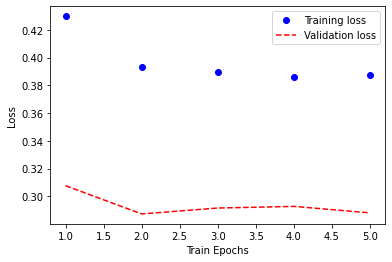

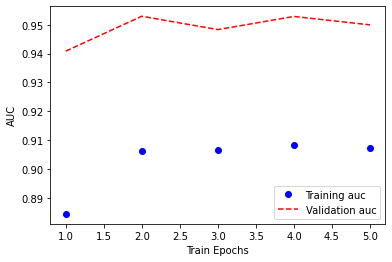

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

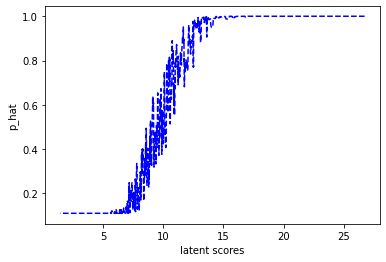

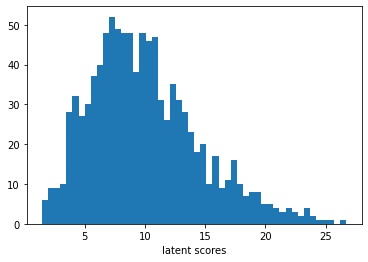

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

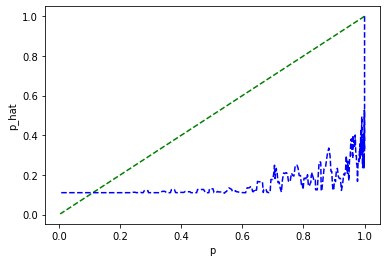

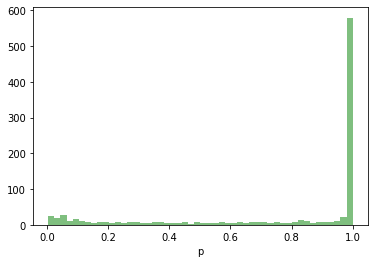

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

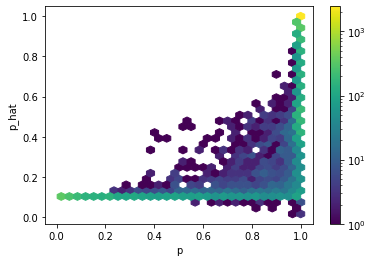

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

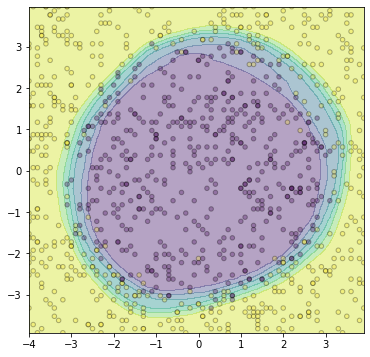

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.005,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'rmsprop',
 'best_loss': {'loss': 0.2775278389453888, 'epoch': 5},
 'best_auc': {'auc': 0.9545493721961975, 'epoch': 4},
 'best_accuracy': {'accuracy': 0.8812999725341797, 'epoch': 6},
 'model': <keras.engine.sequential.Sequential at 0x7fbdae5137c0>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.3286800980567932, 'epoch': 115},
  'best_auc': {'auc': 0.9645751714706421, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.8669000267982483, 'epoch': 65}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.31885460019111633, 'epoch': 84},
  'best_auc': {'auc': 0.9647539854049683, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.8743500113487244, 'epoch': 52}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.32647475600242615, 'epoch': 65},
  'best_auc': {'auc': 0.9645285606384277, 'epoch': 118},
  'best_accuracy': {'accuracy': 0.8695999979972839, 'epoch': 47}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.30427679419517517, 'epoch': 208},
  'best_auc': {'auc': 0.965887188911438, 'epoch': 249},
  'best_

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25